In [ ]:
import numpy as np
import pandas as pd
import pyarrow
import os
from os import listdir
from os.path import isfile, join
from time import time
import re
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import TensorDataset, DataLoader, random_split,DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

# ✅ Use correct path inside Drive
mypath = '/content/drive/MyDrive/the-future-crop-challenge'

In [ ]:
USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.device('cuda:0')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load train

In [ ]:
def get_region(row):
    if -125 <= row['lon'] <= -66 and 24 <= row['lat'] <= 50:
        return 'USA'
    elif -75 <= row['lon'] <= -35 and -40 <= row['lat'] <= -10:
        return 'South America'
    elif -10 <= row['lon'] <= 50 and 35 <= row['lat'] <= 60:
        return 'Europe'
    else:
        return 'Other'

In [ ]:
def load(crop,mode,data_dir):
    tasmax = pd.read_parquet(os.path.join(data_dir, "tasmax_{}_{}.parquet".format(crop,mode)))
    tasmin = pd.read_parquet(os.path.join(data_dir, "tasmin_{}_{}.parquet".format(crop,mode)))
    tas = pd.read_parquet(os.path.join(data_dir, "tas_{}_{}.parquet".format(crop,mode)))
    pr = pd.read_parquet(os.path.join(data_dir, "pr_{}_{}.parquet".format(crop,mode)))
    rsds = pd.read_parquet(os.path.join(data_dir, "rsds_{}_{}.parquet".format(crop,mode)))
    soil_co2 = pd.read_parquet(os.path.join(data_dir, "soil_co2_{}_{}.parquet".format(crop,mode)))

    if mode == 'train':
        yield_ = pd.read_parquet(os.path.join(data_dir, "{}_solutions_{}.parquet".format(mode,crop)))
        yield_ = yield_.values.astype(np.float32)

    if mode == 'test':
        yield_ = None

    climate = np.concatenate([
        tas.values[:, 5:,np.newaxis].astype(np.float32),
        tasmax.values[:, 5:,np.newaxis].astype(np.float32),
        tasmin.values[:, 5:,np.newaxis].astype(np.float32),
        pr.values[:, 5:,np.newaxis].astype(np.float32),
        rsds.values[:, 5:,np.newaxis].astype(np.float32),
    ], axis=2)
    return(climate,yield_,soil_co2)

In [ ]:
def get_training_dataloader(crop, mode, mypath, region, static_var, detrend=True):
    (climate, yield_label, soil) = load(crop, mode, mypath)

    # Reshape and calculate mean and std along grouped axis
    climate_mean = climate.reshape(climate.shape[0], 8, 30, 5).mean(axis=2)
    climate_sd = climate.reshape(climate.shape[0], 8, 30, 5).std(axis=2)

    GPP = np.maximum(climate.reshape(climate.shape[0], 8, 30, 5)[:,:,:,3] - 10, 0).sum(axis=2, keepdims=True).cumsum(axis=1)
    heat_stress_day = (climate.reshape(climate.shape[0], 8, 30, 5)[:,:,:,1] > 30).sum(axis=2, keepdims=True).cumsum(axis=1)
    frost_days = (climate.reshape(climate.shape[0], 8, 30, 5)[:,:,:,2] < 0).sum(axis=2, keepdims=True).cumsum(axis=1)

    climate_stats = np.concatenate([climate_sd, climate_mean, GPP, heat_stress_day, frost_days], axis=2)

    # Annual mean
    annual_df = pd.DataFrame(climate.mean(axis=1), columns=['tas', 'tasmax', 'tasmin', 'pr', 'rsds'])
    soil = soil.reset_index(drop=True)
    soil = pd.concat([annual_df, soil], axis=1)

    soil['region'] = soil.apply(get_region, axis=1)
    soil['co2'] = soil['co2'] / 1500

    # Detrend yield
    soil['yield'] = yield_label
    grouped_mean = soil.groupby(['lon', 'lat'])['yield'].mean().reset_index()
    grouped_mean = grouped_mean.rename(columns={'yield': 'yield_mean'})
    soil = pd.merge(soil, grouped_mean, on=['lon', 'lat'])
    soil['de_yield'] = soil['yield'] - soil['yield_mean']

    # Scale input features
    climate_arr = climate_stats.reshape(-1, climate_stats.shape[2])
    scaler = StandardScaler()
    scaler.fit(climate_arr)
    scaled_climate = scaler.transform(climate_arr).reshape(climate_stats.shape)

    # Scale static features
    scaler_static = StandardScaler()
    static_arr = soil[static_var].values.astype(np.float32)
    scaler_static.fit(static_arr)
    scaled_static = scaler_static.transform(static_arr)
    scaled_static = np.concatenate([scaled_static, soil['co2'].values.reshape(-1, 1)], axis=1)

    # Convert to torch tensors
    X = torch.from_numpy(scaled_climate).float()
    X_static = torch.from_numpy(scaled_static).float()
    y = torch.from_numpy(
        soil['de_yield'].values.reshape(-1, 1) if detrend else soil['yield'].values.reshape(-1, 1)
    ).float()

    dataset = TensorDataset(X, X_static, y)

    # Filter by region
    Region_index = soil[soil['region'].isin(region)].index.values
    dataset = torch.utils.data.Subset(dataset, Region_index)
    soil = soil.loc[Region_index].reset_index(drop=True)  # Align index with Subset

    print(f"After region filtering: {len(dataset)} samples")

    # 🟨 Year-based split using real_year
    if 'real_year' not in soil.columns:
        raise ValueError("'real_year' column not found in soil dataframe.")

    val_indices = soil[soil['real_year'] == 2020].index.tolist()
    train_indices = soil[soil['real_year'] != 2020].index.tolist()

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    # Optional: take last 10% of train as test set
    test_split = int(0.1 * len(train_dataset))
    test_dataset = torch.utils.data.Subset(train_dataset, list(range(len(train_dataset) - test_split, len(train_dataset))))
    train_dataset = torch.utils.data.Subset(train_dataset, list(range(0, len(train_dataset) - test_split)))

    # DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3000, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=3000, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=3000, shuffle=False)

    print(f"Train: {len(train_loader.dataset)}, Val (2020): {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")
    return train_loader, val_loader, test_loader


# Train

In [ ]:
class LSTMForecaster_static(nn.Module):
  def __init__(self, n_features, n_hidden, n_outputs,n_static, n_static_hidden, sequence_len,DEVICE, n_lstm_layers=1, n_deep_layers=10, use_cuda=True, dropout=0.2):
    '''
    n_features: number of input features (1 for univariate forecasting)
    n_hidden: number of neurons in each hidden layer
    n_outputs: number of outputs to predict for each training example
    n_static: number of static features
    n_deep_layers: number of hidden dense layers after the lstm layer
    sequence_len: number of steps to look back at for prediction
    dropout: float (0 < dropout < 1) dropout ratio between dense layers
    '''
    super().__init__()
    self.n_lstm_layers = n_lstm_layers
    self.nhid = n_hidden
    self.use_cuda = use_cuda # set option for device selection
    self.DEVICE = DEVICE # set option for device selection

    # LSTM Layer
    self.lstm = nn.LSTM(n_features,
                        n_hidden,
                        num_layers=n_lstm_layers,
                        batch_first=True) # As we have transformed our data in this way


    # First dense layer to expand static variables
    self.fc1 = nn.Linear(n_static,n_static_hidden)
    self.relu1 = nn.ReLU()

    # Dropout layer
    self.dropout = nn.Dropout(p=dropout)
    # Create fully connected layers (n_hidden x n_deep_layers)
    dnn_layers = []

    # the first layer to concatenate hidden and static properties, 2 additional elements
    dnn_layers.append(nn.ReLU())
    dnn_layers.append(nn.Linear(n_hidden*n_lstm_layers+n_static_hidden, n_hidden))

    for i in range(n_deep_layers):
      # Last layer (n_hidden x n_outputs)
      if i == n_deep_layers - 1:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(n_hidden, n_outputs))
      # All other layers (n_hidden x n_hidden) with dropout option
      else:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(n_hidden, n_hidden))
        if dropout:
          dnn_layers.append(nn.Dropout(p=dropout))
    # compile DNN layers
    self.dnn = nn.Sequential(*dnn_layers)

  def forward(self, x,x_static):

    # Initialize hidden state
    hidden_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)
    cell_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)

    # move hidden state to device
    if self.use_cuda:
      hidden_state = hidden_state.to(self.DEVICE)
      cell_state = cell_state.to(self.DEVICE)

    self.hidden = (hidden_state, cell_state)
    # Forward Pass
    output, (h,c) = self.lstm(x, self.hidden) # LSTM

    # Flatten hidden state of the last step
    x_ = self.dropout(h.contiguous().view(x.shape[0], -1))
    x_static = self.relu1(self.fc1(x_static))
    # Pass forward hidden state and static features through fully connected DNN.
    return self.dnn(torch.cat((x_,x_static),axis=1)).squeeze()

In [ ]:
def train_model(model, train_loader, val_loader, test_loader,static_var,DEVICE,lr, weight_decay,step_size,sch_gamma,num_epochs=100):
    # Initialize the loss function and optimizer
    criterion = nn.MSELoss().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=sch_gamma)
    #static & scaled
    # num_epochs = 100
    train_losses = [] #save performance metrics
    train_r2s = []
    val_losses = []
    val_r2s = []
    model.train()
    for epoch in range(num_epochs):
        start = time()
        model.train()
        for i, (x, x_static, y_true), in enumerate(train_loader):
            # model.train()
            # print(i)
            xt,x_st, yt = x.to(DEVICE),x_static.to(DEVICE),y_true.to(DEVICE).squeeze()

            y_pred = model(xt,x_st)
            loss_batch = criterion(y_pred, yt)
            optimizer.zero_grad()
            loss_batch.backward()
            optimizer.step()
        scheduler.step()

        if epoch % 10 != 0:
            continue
        train_loss,train_r2 = test_mse_r2_static(model, criterion, train_loader,DEVICE)
        val_loss,val_r2 = test_mse_r2_static(model, criterion, val_loader,DEVICE)
        test_loss,test_r2 = test_mse_r2_static(model, criterion, test_loader,DEVICE)

        train_losses.append(train_loss)
        train_r2s.append(train_r2)
        val_losses.append(val_loss)
        val_r2s.append(val_r2)
        end = time()

        print("Epoch %d: TRAIN MSE loss: %.6f, TRAIN r2 loss: %.6f" % (epoch, train_loss,train_r2))
        print("Epoch %d: VAL MSE loss: %.6f, VAL r2: %.6f" % (epoch, val_loss, val_r2))
        print("Epoch %d: TEST MSE loss: %.6f, TEST r2: %.6f" % (epoch, test_loss, test_r2))
        print("Finish with for one epoch:{} second".format(end - start))
    return model

In [ ]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
def test_mse_r2_static(model,loss_fn, dataloader,DEVICE):
    model.eval()
    loss_test_cum = 0
    y_test_pred = []
    y_test_label = []
    with torch.no_grad():
        for i, (x, z, y) in enumerate(dataloader):
            y_pred = model(x.to(DEVICE),z.to(DEVICE))
            # predicted = model(input)
            loss   = loss_fn(y_pred, y.to(DEVICE).squeeze())
            loss_test_cum += loss
            y_test_pred.append(y_pred)
            y_test_label.append(y.to(DEVICE).squeeze())
        r2 = r2_loss(torch.cat(y_test_pred),torch.cat(y_test_label))
    return loss_test_cum/(i+1),r2

In [ ]:
# (climate, yield_label, soil) = load('maize','train',mypath)
static_var=['nitrogen','texture_class','lon','lat','yield_mean','tas', 'tasmax', 'tasmin', 'pr', 'rsds']

# Maize

In [ ]:
## make maize train_loader
train_loader,val_loader,test_loader = get_training_dataloader('maize','train',mypath,region=['USA', 'Other', 'South America', 'Europe'],static_var=static_var)

After region filtering: 349719 samples
Train: 306590, Val (2020): 9064, Test: 34065


In [ ]:
(x,z,y) = next(iter(train_loader))

In [ ]:
# global model training
model = LSTMForecaster_static(n_features = x.shape[2], n_hidden = 200, n_outputs = 1,
                              n_static = len(static_var)+1,n_static_hidden=200,sequence_len = x.shape[1],
                              DEVICE = DEVICE, n_deep_layers=4, use_cuda=USE_CUDA, dropout=0.4).to(DEVICE)

maize_unscale_model_GLOB = train_model(model, train_loader,val_loader,test_loader,static_var,DEVICE,
                                  lr=4e-4, weight_decay=0.1,step_size=100,sch_gamma=0.8,num_epochs=200)

Epoch 0: TRAIN MSE loss: 0.834989, TRAIN r2 loss: 0.268737
Epoch 0: VAL MSE loss: 0.920418, VAL r2: -0.163144
Epoch 0: TEST MSE loss: 0.943356, TEST r2: -0.037391
Finish with for one epoch:12.705683469772339 second
Epoch 10: TRAIN MSE loss: 0.511622, TRAIN r2 loss: 0.551375
Epoch 10: VAL MSE loss: 0.807912, VAL r2: 0.012747
Epoch 10: TEST MSE loss: 0.721255, TEST r2: 0.203785
Finish with for one epoch:11.669317960739136 second
Epoch 20: TRAIN MSE loss: 0.468550, TRAIN r2 loss: 0.589629
Epoch 20: VAL MSE loss: 0.551746, VAL r2: 0.320322
Epoch 20: TEST MSE loss: 0.559522, TEST r2: 0.380986
Finish with for one epoch:12.273164987564087 second
Epoch 30: TRAIN MSE loss: 0.430818, TRAIN r2 loss: 0.622975
Epoch 30: VAL MSE loss: 0.822749, VAL r2: -0.032510
Epoch 30: TEST MSE loss: 0.758604, TEST r2: 0.158980
Finish with for one epoch:11.998587846755981 second
Epoch 40: TRAIN MSE loss: 0.352128, TRAIN r2 loss: 0.691996
Epoch 40: VAL MSE loss: 0.576301, VAL r2: 0.265861
Epoch 40: TEST MSE loss: 

# Wheat

In [ ]:
## make wheat train_loader
train_loader,val_loader,test_loader = get_training_dataloader('wheat','train',mypath,
                                                              region=['USA', 'Other', 'South America', 'Europe'],static_var=static_var)

After region filtering: 278747 samples
Train: 244413, Val (2020): 7178, Test: 27156


In [ ]:
(x,z,y) = next(iter(train_loader))

In [ ]:
# # global model training
model = LSTMForecaster_static(
    n_features = x.shape[2],
    n_hidden = 128,
    n_outputs = 1,
    n_static = len(static_var) + 1,
    n_static_hidden = 128,
    sequence_len = x.shape[1],
    DEVICE = DEVICE,
    n_lstm_layers = 1,
    n_deep_layers = 3,
    use_cuda = USE_CUDA,
    dropout = 0.4
).to(DEVICE)

wheat_unscale_model_GLOB = train_model(model, train_loader,val_loader,test_loader,static_var,DEVICE,
                                   lr=4e-4, weight_decay=0.01,step_size=50,sch_gamma=0.8,num_epochs=200)

Epoch 0: TRAIN MSE loss: 0.505632, TRAIN r2 loss: 0.059309
Epoch 0: VAL MSE loss: 0.471490, VAL r2: 0.068099
Epoch 0: TEST MSE loss: 0.556809, TEST r2: 0.077155
Finish with for one epoch:9.643620252609253 second
Epoch 10: TRAIN MSE loss: 0.408327, TRAIN r2 loss: 0.240211
Epoch 10: VAL MSE loss: 0.406179, VAL r2: 0.198663
Epoch 10: TEST MSE loss: 0.455010, TEST r2: 0.237076
Finish with for one epoch:9.4281587600708 second
Epoch 20: TRAIN MSE loss: 0.351397, TRAIN r2 loss: 0.345750
Epoch 20: VAL MSE loss: 0.468257, VAL r2: 0.062348
Epoch 20: TEST MSE loss: 0.467471, TEST r2: 0.198758
Finish with for one epoch:9.409531354904175 second
Epoch 30: TRAIN MSE loss: 0.318842, TRAIN r2 loss: 0.406730
Epoch 30: VAL MSE loss: 0.454300, VAL r2: 0.094091
Epoch 30: TEST MSE loss: 0.473381, TEST r2: 0.199990
Finish with for one epoch:9.367065191268921 second
Epoch 40: TRAIN MSE loss: 0.290833, TRAIN r2 loss: 0.459003
Epoch 40: VAL MSE loss: 0.466893, VAL r2: 0.064447
Epoch 40: TEST MSE loss: 0.483855,

# Evaluation

## Test climate stats

In [ ]:
def get_test_dataloader(climate,climate_test,soil,soil_test,region,static_var):
    # Reshape and calculate mean and sd along the grouped axis
    climate_test_mean = climate_test.reshape(climate_test.shape[0], 8, 30, 5).mean(axis=2)
    climate_test_sd = climate_test.reshape(climate_test.shape[0], 8, 30, 5).std(axis=2)
    GPP_test = np.maximum(climate_test.reshape(climate_test.shape[0], 8, 30, 5)[:,:,:,3] - 10, 0).sum(axis=2,keepdims=True).cumsum(axis=1) # cumulative GDD by phases
    heat_stress_day_test =  (climate_test.reshape(climate_test.shape[0], 8, 30, 5)[:,:,:,1] > 30).sum(axis=2,keepdims=True).cumsum(axis=1)
    frost_days_test = (climate_test.reshape(climate_test.shape[0], 8, 30, 5)[:,:,:,2] < 0).sum(axis=2,keepdims=True).cumsum(axis=1)
    climate_test_stats = np.concatenate([climate_test_sd,climate_test_mean,GPP_test,heat_stress_day_test,frost_days_test],axis=2)

    climate_mean = climate.reshape(climate.shape[0], 8, 30, 5).mean(axis=2)
    climate_sd = climate.reshape(climate.shape[0], 8, 30, 5).std(axis=2)
    GPP = np.maximum(climate.reshape(climate.shape[0], 8, 30, 5)[:,:,:,3] - 10, 0).sum(axis=2,keepdims=True).cumsum(axis=1) # cumulative GDD by phases
    heat_stress_day =  (climate.reshape(climate.shape[0], 8, 30, 5)[:,:,:,1] > 30).sum(axis=2,keepdims=True).cumsum(axis=1)
    frost_days = (climate.reshape(climate.shape[0], 8, 30, 5)[:,:,:,2] < 0).sum(axis=2,keepdims=True).cumsum(axis=1)
    climate_stats = np.concatenate([climate_sd,climate_mean,GPP,heat_stress_day,frost_days],axis=2)

    #annual mean for test
    annual_test_df = pd.DataFrame(climate_test.mean(axis=1),columns=['tas', 'tasmax', 'tasmin', 'pr', 'rsds'])
    soil_test = pd.concat([annual_test_df, soil_test], axis=1)

    #annual mean for train
    annual_df = pd.DataFrame(climate.mean(axis=1),columns=['tas', 'tasmax', 'tasmin', 'pr', 'rsds'])
    soil = pd.concat([annual_df, soil], axis=1)

    #scale input features
    climate_arr = climate_stats.reshape(-1, climate_stats.shape[2])
    scaler = StandardScaler()
    scaler.fit(climate_arr)
    # scaled_climate = scaler.transform(climate_arr).reshape(climate_stats.shape)

    #scale static features
    scaler_static = StandardScaler()
    static_arr = soil[static_var].values.astype(np.float32)
    scaler_static.fit(static_arr)
    # scaler_static.fit(static_arr)

    climate_test_arr = climate_test_stats.reshape(-1, climate_test_stats.shape[2])
    climate_test_scale = scaler.transform(climate_test_arr).reshape(climate_test_stats.shape)

    static_test_arr = soil_test[static_var].values.astype(np.float32)
    static_test = scaler_static.transform(static_test_arr)
    #add co2
    soil_test['co2'] = soil_test['co2']/1500
    static_test = np.concatenate([static_test,soil_test['co2'].values.reshape(-1, 1)],axis = 1)

    X_test_to_loader = torch.from_numpy(climate_test_scale).type(torch.FloatTensor)
    static_test_loader = torch.from_numpy(static_test).type(torch.FloatTensor)

    dataset = TensorDataset(X_test_to_loader, static_test_loader)

    # subset by REGION
    Region_index = soil_test[soil_test['region'].isin(region)].index.values
    dataset = torch.utils.data.Subset(dataset, Region_index)
    print(len(dataset))

    test_loader_stats = torch.utils.data.DataLoader(dataset, 2000, shuffle=False)

    return soil_test, Region_index, test_loader_stats

### Maize

In [ ]:
## make maize test_loader
crop = 'maize'
(climate, yield_label, soil) = load(crop,'train', mypath)
(climate_test, yield_, soil_test_maize) = load(crop,'test', mypath)

In [ ]:
#detrend yield
soil = soil.reset_index()
soil['yield'] = yield_label
grouped_mean = soil.groupby(['lon', 'lat'])['yield'].mean().reset_index()
grouped_mean = grouped_mean.rename(columns={'yield': 'yield_mean'})
soil = pd.merge(soil, grouped_mean, on=['lon', 'lat'])

soil_test_maize = soil_test_maize.reset_index()
soil_test_maize = pd.merge(soil_test_maize, grouped_mean, on=['lon', 'lat'])

soil['de_yield'] = soil['yield']-soil['yield_mean']
soil['region'] = soil.apply(get_region, axis=1)
soil_test_maize['region'] = soil_test_maize.apply(get_region, axis=1)

In [ ]:
test_soil, Region_index_US, test_loader_US = get_test_dataloader(climate,climate_test,soil,soil_test_maize,region=['USA', 'Other', 'South America', 'Europe'],static_var=static_var)

691271


In [ ]:
maize_pred_stats_test = []
for i, (x,z) in enumerate(test_loader_US):
    with torch.no_grad():
        # y_pred = maize_unscale_model_US(x.to(DEVICE),z.to(DEVICE))
        y_pred = maize_unscale_model_GLOB(x.to(DEVICE),z.to(DEVICE))
        maize_pred_stats_test.append(y_pred.detach().cpu().numpy())

### Wheat

In [ ]:
## make wheat test_loader
crop = 'wheat'
(climate, yield_label, soil) = load(crop,'train', mypath)
(climate_test, yield_, soil_test_wheat) = load(crop,'test', mypath)

In [ ]:
#detrend yield
soil = soil.reset_index()
soil['yield'] = yield_label
grouped_mean = soil.groupby(['lon', 'lat'])['yield'].mean().reset_index()
grouped_mean = grouped_mean.rename(columns={'yield': 'yield_mean'})
soil = pd.merge(soil, grouped_mean, on=['lon', 'lat'])

soil_test_wheat = soil_test_wheat.reset_index()
soil_test_wheat = pd.merge(soil_test_wheat, grouped_mean, on=['lon', 'lat'])

soil['de_yield'] = soil['yield']-soil['yield_mean']
soil['region'] = soil.apply(get_region, axis=1)
soil_test_wheat['region'] = soil_test_wheat.apply(get_region, axis=1)

In [ ]:
test_soil, Region_index_US, test_loader_US = get_test_dataloader(climate,climate_test,soil,soil_test_wheat,region=['USA', 'Other', 'South America', 'Europe'],static_var=static_var)

553878


In [ ]:
wheat_pred_stats_test = []
for i, (x,z) in enumerate(test_loader_US):
    with torch.no_grad():
        # y_pred = maize_unscale_model_US(x.to(DEVICE),z.to(DEVICE))
        y_pred = wheat_unscale_model_GLOB(x.to(DEVICE),z.to(DEVICE))
        wheat_pred_stats_test.append(y_pred.detach().cpu().numpy())

# Create submission

In [ ]:
sub_v5 = pd.read_csv('/content/drive/MyDrive/the-future-crop-challenge/sample_submission.csv')

In [ ]:
soil_test_maize['preds_stats'] = np.concatenate(maize_pred_stats_test)
soil_test_maize['preds_yield']  = soil_test_maize['preds_stats'] +soil_test_maize['yield_mean']
soil_test_maize['preds_yield'] =  soil_test_maize['preds_yield'].where(soil_test_maize['preds_yield'] >=0, soil_test_maize['yield_mean'] )
soil_test_maize.describe()

,ID,year,lon,lat,texture_class,real_year,co2,nitrogen,yield_mean,preds_stats,preds_yield
count,6.912710e+05,691271.000000,691271.000000,691271.000000,691271.000000,691271.000000,691271.000000,691271.000000,691271.000000,691271.000000,691271.000000
mean,6.953540e+05,458.277314,10.275572,20.969290,7.935973,2059.277314,682.671409,99.545616,3.708594,-0.580539,3.133784
std,1.995529e+05,22.513611,69.021991,26.576938,3.009716,22.513611,206.179701,90.400169,2.544591,1.006224,2.230795
min,3.497190e+05,420.000000,-122.250000,-38.750000,1.000000,2021.000000,418.060000,0.367000,0.061852,-12.528625,0.000299
25%,5.225365e+05,439.000000,-53.750000,-1.250000,7.000000,2040.000000,500.020000,7.405000,1.707421,-0.798459,1.443490
50%,6.953540e+05,458.000000,19.750000,25.750000,9.000000,2059.000000,634.110000,75.408997,2.984158,-0.259294,2.494997
75%,8.681715e+05,478.000000,53.750000,44.750000,10.000000,2079.000000,851.450000,186.110992,5.076590,-0.018202,4.275599
max,1.040989e+06,497.000000,137.750000,58.250000,13.000000,2098.000000,1107.890000,647.017029,13.838435,7.423072,17.780815


In [ ]:
soil_test_wheat['preds_stats'] = np.concatenate(wheat_pred_stats_test)
soil_test_wheat['preds_yield']  = soil_test_wheat['preds_stats'] +soil_test_wheat['yield_mean']
soil_test_wheat['preds_yield'] =  soil_test_wheat['preds_yield'].where(soil_test_wheat['preds_yield'] >=0, soil_test_wheat['yield_mean'] )
soil_test_wheat.describe()

,ID,year,lon,lat,texture_class,real_year,co2,nitrogen,yield_mean,preds_stats,preds_yield
count,5.538780e+05,553878.000000,553878.000000,553878.000000,553878.000000,553878.000000,553878.000000,553878.000000,553878.000000,553878.000000,553878.000000
mean,1.596727e+06,458.460103,16.979375,35.521157,7.926554,2059.460591,684.215957,83.510223,2.840958,0.400918,3.242258
std,1.599219e+05,22.486473,71.507888,25.908260,2.437504,22.486447,206.244264,74.410942,1.728577,0.796743,2.151427
min,1.319737e+06,420.000000,-123.250000,-41.250000,1.000000,2021.000000,418.060000,4.212000,0.000000,-4.934601,0.000000
25%,1.458229e+06,439.000000,-8.250000,34.750000,7.000000,2040.000000,500.020000,5.351000,1.681316,0.001836,1.815909
50%,1.596732e+06,458.000000,26.250000,43.750000,9.000000,2059.000000,634.110000,78.544998,2.426079,0.229525,2.755936
75%,1.735219e+06,478.000000,65.250000,51.250000,9.000000,2079.000000,851.450000,105.491997,3.486462,0.614228,4.010048
max,1.873721e+06,497.000000,152.750000,64.750000,13.000000,2099.000000,1121.550000,317.987000,11.219384,11.244667,19.996140


In [ ]:
sub_v5.loc[sub_v5['ID'].isin(soil_test_maize['ID']),'yield']  = soil_test_maize['preds_yield'].values
sub_v5.loc[sub_v5['ID'].isin(soil_test_wheat['ID']),'yield']  = soil_test_wheat['preds_yield'].values

In [ ]:
sub_v5.to_csv('submission.csv',index=0)

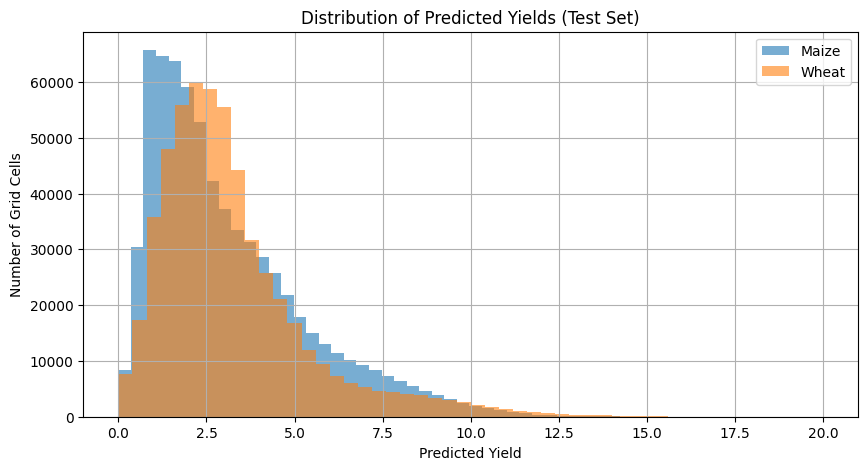

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(soil_test_maize['preds_yield'], bins=50, alpha=0.6, label='Maize')
plt.hist(soil_test_wheat['preds_yield'], bins=50, alpha=0.6, label='Wheat')
plt.xlabel('Predicted Yield')
plt.ylabel('Number of Grid Cells')
plt.title('Distribution of Predicted Yields (Test Set)')
plt.legend()
plt.grid(True)
plt.show()


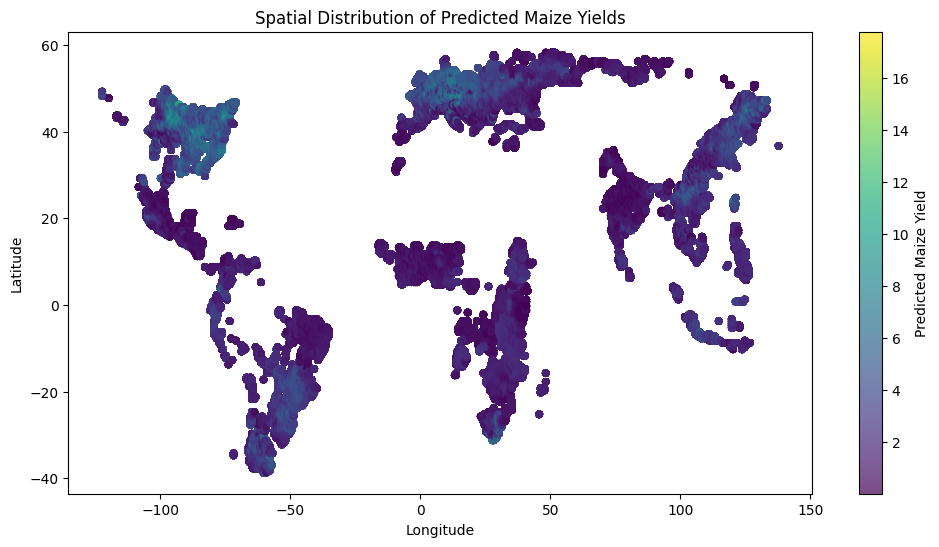

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(soil_test_maize['lon'], soil_test_maize['lat'],
            c=soil_test_maize['preds_yield'],  s=20, alpha=0.7)
plt.colorbar(label='Predicted Maize Yield')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Predicted Maize Yields')
plt.show()

In [ ]:
static_var=['nitrogen','texture_class','lon','lat','yield_mean','tas', 'tasmax', 'tasmin', 'pr', 'rsds']

# For Maize
_, _, maize_test_loader = get_training_dataloader(
    'maize', 'train', mypath,
    region=['USA', 'Other', 'South America', 'Europe'],
    static_var=static_var
)

# For Wheat
_, _, wheat_test_loader = get_training_dataloader(
    'wheat', 'train', mypath,
    region=['USA', 'Other', 'South America', 'Europe'],
    static_var=static_var
)


After region filtering: 349719 samples
Train: 306590, Val (2020): 9064, Test: 34065
After region filtering: 278747 samples
Train: 244413, Val (2020): 7178, Test: 27156


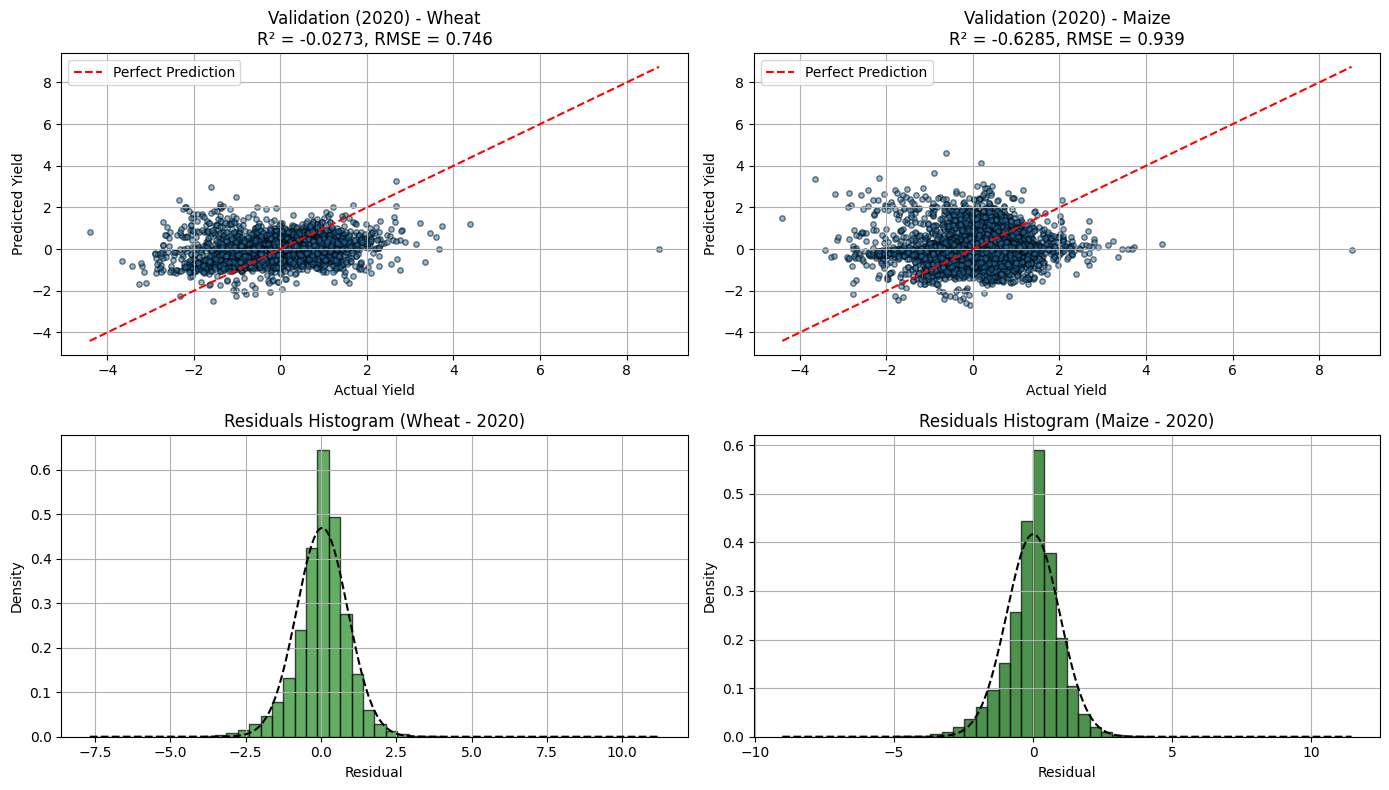

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_lstm(model, test_loader, title_prefix=""):
    model.eval()
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for x, x_static, y_true in test_loader:
            y_pred = model(x.to(DEVICE), x_static.to(DEVICE)).cpu().numpy()
            y_true = y_true.cpu().numpy()
            y_true_all.append(y_true)
            y_pred_all.append(y_pred)

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)
    residuals = y_true_all - y_pred_all
    r2 = r2_score(y_true_all, y_pred_all)
    rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))

    return y_true_all, y_pred_all, residuals, r2, rmse

# --- Evaluate both models on 2020 validation set ---
y_true_wheat, y_pred_wheat, resid_wheat, r2_wheat, rmse_wheat = evaluate_lstm(wheat_unscale_model_GLOB, val_loader, "Wheat (2020)")
y_true_maize, y_pred_maize, resid_maize, r2_maize, rmse_maize = evaluate_lstm(maize_unscale_model_GLOB, val_loader, "Maize (2020)")

# --- Plotting ---
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# 1. Wheat: Pred vs Actual
axs[0, 0].scatter(y_true_wheat, y_pred_wheat, alpha=0.5, s=15, edgecolor='k')
axs[0, 0].plot([y_true_wheat.min(), y_true_wheat.max()],
               [y_true_wheat.min(), y_true_wheat.max()],
               'r--', label='Perfect Prediction')
axs[0, 0].set_title(f'Validation (2020) - Wheat\nR² = {r2_wheat:.4f}, RMSE = {rmse_wheat:.3f}')
axs[0, 0].set_xlabel("Actual Yield")
axs[0, 0].set_ylabel("Predicted Yield")
axs[0, 0].legend()
axs[0, 0].grid(True)

# 2. Maize: Pred vs Actual
axs[0, 1].scatter(y_true_maize, y_pred_maize, alpha=0.5, s=15, edgecolor='k')
axs[0, 1].plot([y_true_maize.min(), y_true_maize.max()],
               [y_true_maize.min(), y_true_maize.max()],
               'r--', label='Perfect Prediction')
axs[0, 1].set_title(f'Validation (2020) - Maize\nR² = {r2_maize:.4f}, RMSE = {rmse_maize:.3f}')
axs[0, 1].set_xlabel("Actual Yield")
axs[0, 1].set_ylabel("Predicted Yield")
axs[0, 1].legend()
axs[0, 1].grid(True)

# 3. Residuals Histogram - Wheat
resid_w = resid_wheat.ravel()
mean_w, std_w = np.mean(resid_w), np.std(resid_w)
x_w = np.linspace(resid_w.min(), resid_w.max(), 500)
pdf_w = (1 / (std_w * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_w - mean_w) / std_w) ** 2)
axs[1, 0].hist(resid_w, bins=50, color='forestgreen', edgecolor='black', alpha=0.7, density=True)
axs[1, 0].plot(x_w, pdf_w, 'k--')
axs[1, 0].set_title('Residuals Histogram (Wheat - 2020)')
axs[1, 0].set_xlabel("Residual")
axs[1, 0].set_ylabel("Density")
axs[1, 0].grid(True)

# 4. Residuals Histogram - Maize
resid_m = resid_maize.ravel()
mean_m, std_m = np.mean(resid_m), np.std(resid_m)
x_m = np.linspace(resid_m.min(), resid_m.max(), 500)
pdf_m = (1 / (std_m * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_m - mean_m) / std_m) ** 2)
axs[1, 1].hist(resid_m, bins=50, color='darkgreen', edgecolor='black', alpha=0.7, density=True)
axs[1, 1].plot(x_m, pdf_m, 'k--')
axs[1, 1].set_title('Residuals Histogram (Maize - 2020)')
axs[1, 1].set_xlabel("Residual")
axs[1, 1].set_ylabel("Density")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()